In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss

import os, eli5, shap
from eli5.sklearn import PermutationImportance

In [96]:
os.getcwd()

'C:\\Users\\MaxCarduner\\DS\\NCAA_19'

In [98]:
os.chdir('C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final')

In [2]:
import glob

### load data into dictionary for easy access

In [99]:
data_dict = {}
for i in glob.glob('C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\*'):
    name = i.split('\\')[-1].split('.')[0]
    print(i)
    if name != 'TeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='latin-1')

C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\Cities.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\Conferences.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\ConferenceTourneyGames.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\GameCities.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\NCAATourneyCompactResults.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\NCAATourneyDetailedResults.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\NCAATourneySeedRoundSlots.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\NCAATourneySeeds.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\NCAATourneySlots.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\RegularSeasonCompactResults.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\RegularSeasonDetailedResults.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\Seasons.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\SecondaryTourneyCompactResults.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\SecondaryTourneyTeams.csv
C:\Users\MaxCarduner\DS\NCAA_19_Final\Data\TeamCoaches.csv

In [100]:
data_dict.keys()

dict_keys(['Cities', 'Conferences', 'ConferenceTourneyGames', 'GameCities', 'NCAATourneyCompactResults', 'NCAATourneyDetailedResults', 'NCAATourneySeedRoundSlots', 'NCAATourneySeeds', 'NCAATourneySlots', 'RegularSeasonCompactResults', 'RegularSeasonDetailedResults', 'Seasons', 'SecondaryTourneyCompactResults', 'SecondaryTourneyTeams', 'TeamCoaches', 'TeamConferences', 'Teams', 'TeamSpellings'])

In [101]:
df_tourney_all = data_dict['NCAATourneyCompactResults']
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [102]:
df = data_dict['RegularSeasonDetailedResults']
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


### Data Cleanup (Add Team and Conference Names for Graphs)

In [103]:
# Drop columns that are not needed:
df = df.drop(['DayNum', 'WLoc', 'NumOT'], axis=1)

#save dfs with team and conf names
df_teams = data_dict['Teams']
df_team_conferences = data_dict['TeamConferences']
df_conferences = data_dict['Conferences']

# Merge the conference dataframes to eventually use the full conference name:
df_conference_names = df_team_conferences.merge(df_conferences, on=['ConfAbbrev'])

# Pre-merge tidying to match with winner and loser IDs:
win_teams = df_teams.rename(columns={'TeamID':'WTeamID'})[['WTeamID', 'TeamName']]
win_confs = df_conference_names.rename(columns={'TeamID':'WTeamID'})[['Season', 'WTeamID', 'Description']]
lose_teams = df_teams.rename(columns={'TeamID':'LTeamID'})[['LTeamID', 'TeamName']]
lose_confs = df_conference_names.rename(columns={'TeamID':'LTeamID'})[['Season', 'LTeamID', 'Description']]

# Merge winning team name and conference, losing team name and conference with season results:
df = df.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})
df.head()

,Season,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName
0,2003,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,Alabama,Southeastern Conference,Oklahoma,Big 12 Conference
1,2003,1400,67,1328,61,25,64,5,14,12,20,18,24,10,10,5,4,16,22,52,7,14,10,15,9,25,5,14,5,3,20,Texas,Big 12 Conference,Oklahoma,Big 12 Conference
2,2003,1400,76,1328,71,27,50,6,11,16,25,9,28,13,13,5,0,21,25,60,8,21,13,23,15,19,16,9,8,6,23,Texas,Big 12 Conference,Oklahoma,Big 12 Conference
3,2003,1281,67,1328,52,24,55,7,15,12,14,10,24,14,5,4,5,18,15,55,5,23,17,19,17,22,8,11,1,3,17,Missouri,Big 12 Conference,Oklahoma,Big 12 Conference
4,2003,1329,48,1328,46,19,49,1,8,9,16,10,28,4,8,4,6,17,18,55,3,12,7,15,15,23,10,6,4,3,18,Oklahoma St,Big 12 Conference,Oklahoma,Big 12 Conference


In [106]:
df.tail()

,Season,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName,WFGM2,WFGA2,LFGM2,LFGA2
87499,2019,1430,64,1465,63,22,62,6,21,14,18,20,25,6,13,5,2,13,25,63,8,25,5,7,14,23,9,11,4,5,20,Utah Valley,Western Athletic Conference,Cal Baptist,Western Athletic Conference,16,41,17,38
87500,2019,1167,88,1465,84,35,77,6,19,12,16,23,22,16,12,11,3,16,30,61,11,32,13,16,10,20,11,15,7,3,16,CS Bakersfield,Western Athletic Conference,Cal Baptist,Western Athletic Conference,29,58,19,29
87501,2019,1370,67,1465,65,27,61,8,22,5,7,12,28,10,13,3,3,20,17,53,6,20,25,32,12,23,6,7,8,4,13,Seattle,Western Athletic Conference,Cal Baptist,Western Athletic Conference,19,39,11,33
87502,2019,1213,90,1465,73,34,66,7,23,15,22,14,20,12,6,10,1,21,25,49,11,20,12,17,6,21,14,16,1,3,20,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference,27,43,14,29
87503,2019,1213,91,1465,58,30,59,13,29,18,20,7,30,21,10,8,5,15,23,62,5,26,7,8,10,24,6,17,3,1,15,Grand Canyon,Western Athletic Conference,Cal Baptist,Western Athletic Conference,17,30,18,36


In [104]:
df['WFGM2'] = df.WFGM - df.WFGM3
df['WFGA2'] = df.WFGA - df.WFGA3
df['LFGM2'] = df.LFGM - df.LFGM3
df['LFGA2'] = df.LFGA - df.LFGA3

In [105]:
print('These are the {} conferences that have participated in NCAA Division I men\'s basketball with the number of wins in the dataset for each:'.format(len(df.WConfName.value_counts())))
df.WConfName.value_counts()

These are the 36 conferences that have participated in NCAA Division I men's basketball with the number of wins in the dataset for each:


Big East Conference                   4310
Atlantic Coast Conference             4175
Southeastern Conference               4081
Big Ten Conference                    3893
Atlantic 10 Conference                3882
Big 12 Conference                     3608
Conference USA                        3514
Mid-American Conference               3141
Colonial Athletic Association         2823
Sun Belt Conference                   2811
Missouri Valley Conference            2807
Mountain West Conference              2727
Metro Atlantic Athletic Conference    2624
Southern Conference                   2544
Ohio Valley Conference                2460
Northeast Conference                  2450
Southland Conference                  2433
Horizon League                        2374
Mid-Eastern Athletic Conference       2352
West Coast Conference                 2343
Western Athletic Conference           2284
Atlantic Sun Conference               2216
America East Conference               2119
Big West Co

In [107]:
print('Season  Games:')
df.Season.value_counts()

Season  Games:


2019    5463
2018    5405
2017    5395
2016    5369
2014    5362
2015    5354
2013    5320
2010    5263
2012    5253
2009    5249
2011    5246
2008    5163
2007    5043
2006    4757
2005    4675
2003    4616
2004    4571
Name: Season, dtype: int64

In [108]:
# Check winner boxscore data needed to calculate stats:
df[['WFGA', 'WFTA', 'WTO', 'WOR', 'WScore', 'WFGM2', 'WFGM3', 'WFGM', 'WFTM', 'WDR', 'WAst', 'WStl', 'WBlk', 'WPF']].describe()

,WFGA,WFTA,WTO,WOR,WScore,WFGM2,WFGM3,WFGM,WFTM,WDR,WAst,WStl,WBlk,WPF
count,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000
mean,55.174266,22.659113,12.975464,10.900290,75.429580,18.996846,7.114646,26.111492,16.091950,25.677066,14.738423,7.008777,3.830899,17.451477
std,7.564707,8.123213,4.026165,4.132544,11.131958,4.691893,3.070932,4.700220,6.249622,4.909033,4.412361,3.123401,2.460668,4.136628
min,27.000000,0.000000,1.000000,0.000000,34.000000,2.000000,0.000000,10.000000,0.000000,5.000000,1.000000,0.000000,0.000000,3.000000
25%,50.000000,17.000000,10.000000,8.000000,68.000000,16.000000,5.000000,23.000000,12.000000,22.000000,12.000000,5.000000,2.000000,15.000000
50%,55.000000,22.000000,13.000000,11.000000,75.000000,19.000000,7.000000,26.000000,16.000000,26.000000,14.000000,7.000000,3.000000,17.000000
75%,60.000000,28.000000,16.000000,13.000000,82.000000,22.000000,9.000000,29.000000,20.000000,29.000000,18.000000,9.000000,5.000000,20.000000
max,103.000000,67.000000,33.000000,38.000000,144.000000,48.000000,26.000000,56.000000,48.000000,53.000000,40.000000,26.000000,21.000000,41.000000


In [109]:
# Check loser boxscore data needed to calculate stats:
df[['LFGA', 'LFTA', 'LTO', 'LOR', 'LScore', 'LFGM2', 'LFGM3', 'LFGM', 'LFTM', 'LDR', 'LAst', 'LStl', 'LBlk', 'LPF']].describe()

,LFGA,LFTA,LTO,LOR,LScore,LFGM2,LFGM3,LFGM,LFTM,LDR,LAst,LStl,LBlk,LPF
count,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000
mean,56.392691,18.039244,14.313826,11.115526,63.437866,16.538307,6.058043,22.596350,12.187123,21.631525,11.439706,6.008422,2.870749,19.766811
std,7.686611,7.143685,4.407597,4.207721,10.974796,4.307365,2.781245,4.388046,5.368036,4.543547,3.732508,2.766675,2.037376,4.528199
min,26.000000,0.000000,0.000000,0.000000,20.000000,2.000000,0.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,4.000000
25%,51.000000,13.000000,11.000000,8.000000,56.000000,14.000000,4.000000,20.000000,8.000000,19.000000,9.000000,4.000000,1.000000,17.000000
50%,56.000000,18.000000,14.000000,11.000000,63.000000,16.000000,6.000000,22.000000,12.000000,21.000000,11.000000,6.000000,3.000000,20.000000
75%,61.000000,23.000000,17.000000,14.000000,70.000000,19.000000,8.000000,25.000000,16.000000,25.000000,14.000000,8.000000,4.000000,23.000000
max,106.000000,61.000000,41.000000,36.000000,140.000000,40.000000,22.000000,47.000000,42.000000,49.000000,31.000000,22.000000,18.000000,45.000000


### Calculate Advanced Statistics

In [110]:
# Winner stats related to offensive efficiency:
df['Wposs'] = df.apply(lambda row: row.WFGA + 0.475 * row.WFTA + row.WTO - row.WOR, axis=1)
df['Wshoot_eff'] = df.apply(lambda row: row.WScore / (row.WFGA + 0.475 * row.WFTA), axis=1)
df['Wscore_op'] = df.apply(lambda row: (row.WFGA + 0.475 * row.WFTA) / row.Wposs, axis=1)
df['Woff_rtg'] = df.apply(lambda row: row.WScore/row.Wposs*100, axis=1)

# Loser stats related to offensive efficiency:
df['Lposs'] = df.apply(lambda row: row.LFGA + 0.475 * row.LFTA + row.LTO - row.LOR, axis=1)
df['Lshoot_eff'] = df.apply(lambda row: row.LScore / (row.LFGA + 0.475 * row.LFTA), axis=1)
df['Lscore_op'] = df.apply(lambda row: (row.LFGA + 0.475 * row.LFTA) / row.Lposs, axis=1)
df['Loff_rtg'] = df.apply(lambda row: row.LScore/row.Lposs*100, axis=1)

# Defensive and net efficiency:
df['Wdef_rtg'] = df.apply(lambda row: row.Loff_rtg, axis=1)
df['Wsos'] = df.apply(lambda row: row.Woff_rtg - row.Loff_rtg, axis=1)
df['Ldef_rtg'] = df.apply(lambda row: row.Woff_rtg, axis=1)
df['Lsos'] = df.apply(lambda row: row.Loff_rtg - row.Woff_rtg, axis=1)

# Impact Estimate - 
# First calculate the teams' overall statistical contribution (the numerator):
Wie = df.apply(lambda row: row.WScore + row.WFGM + row.WFTM - row.WFGA - row.WFTA + row.WDR + (0.5 * row.WOR) + row.WAst + row.WStl + (0.5 * row.WBlk) - row.WPF - row.WTO, axis=1)
Lie = df.apply(lambda row: row.LScore + row.LFGM + row.LFTM - row.LFGA - row.LFTA + row.LDR + (0.5 * row.LOR) + row.LAst + row.LStl + (0.5 * row.LBlk) - row.LPF - row.LTO, axis=1)

# Then divide by the total game statistics (the denominator):
df['Wie'] = Wie / (Wie + Lie) * 100
df['Lie'] = Lie / (Lie + Wie) * 100

# Other winner stats:
df['Wts_pct'] = df.apply(lambda row: row.WScore / (2 * (row.WFGA + 0.475 * row.WFTA)) * 100, axis=1)
df['Wefg_pct'] = df.apply(lambda row: (row.WFGM2 + 1.5 * row.WFGM3) / row.WFGA, axis=1)
df['Worb_pct'] = df.apply(lambda row: row.WOR / (row.WOR + row.LDR), axis=1)
df['Wdrb_pct'] = df.apply(lambda row: row.WDR / (row.WDR + row.LOR), axis=1)
df['Wreb_pct'] = df.apply(lambda row: (row.Worb_pct + row.Wdrb_pct) / 2, axis=1)
df['Wto_poss'] = df.apply(lambda row: row.WTO / row.Wposs, axis=1)
df['Wft_rate'] = df.apply(lambda row: row.WFTM / row.WFGA, axis=1)
df['Wast_rtio'] = df.apply(lambda row: row.WAst / (row.WFGA + 0.475*row.WFTA + row.WTO + row.WAst) * 100, axis=1)
df['Wblk_pct'] = df.apply(lambda row: row.WBlk / row.LFGA2 * 100, axis=1)
df['Wstl_pct'] = df.apply(lambda row: row.WStl / row.Lposs * 100, axis=1)

# Other loser stats:
df['Lts_pct'] = df.apply(lambda row: row.LScore / (2 * (row.LFGA + 0.475 * row.LFTA)) * 100, axis=1)
df['Lefg_pct'] = df.apply(lambda row: (row.LFGM2 + 1.5 * row.LFGM3) / row.LFGA, axis=1)
df['Lorb_pct'] = df.apply(lambda row: row.LOR / (row.LOR + row.WDR), axis=1)
df['Ldrb_pct'] = df.apply(lambda row: row.LDR / (row.LDR + row.WOR), axis=1)
df['Lreb_pct'] = df.apply(lambda row: (row.Lorb_pct + row.Ldrb_pct) / 2, axis=1)
df['Lto_poss'] = df.apply(lambda row: row.LTO / row.Lposs, axis=1)
df['Lft_rate'] = df.apply(lambda row: row.LFTM / row.LFGA, axis=1)
df['Last_rtio'] = df.apply(lambda row: row.LAst / (row.LFGA + 0.475*row.LFTA + row.LTO + row.LAst) * 100, axis=1)
df['Lblk_pct'] = df.apply(lambda row: row.LBlk / row.WFGA2 * 100, axis=1)
df['Lstl_pct'] = df.apply(lambda row: row.LStl / row.Wposs * 100, axis=1)

In [111]:
df.head()

,Season,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WTeamName,WConfName,LTeamName,LConfName,WFGM2,WFGA2,LFGM2,LFGA2,Wposs,Wshoot_eff,Wscore_op,Woff_rtg,Lposs,Lshoot_eff,Lscore_op,Loff_rtg,Wdef_rtg,Wsos,Ldef_rtg,Lsos,Wie,Lie,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wast_rtio,Wblk_pct,Wstl_pct,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Last_rtio,Lblk_pct,Lstl_pct
0,2003,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,Alabama,Southeastern Conference,Oklahoma,Big 12 Conference,24,44,20,43,75.550,1.021788,0.880874,90.006618,71.450,0.977147,0.888034,86.773968,86.773968,3.232650,90.006618,-3.232650,53.284672,46.715328,51.089406,0.491379,0.388889,0.705882,0.547386,0.304434,0.189655,12.676743,2.325581,9.797061,48.857368,0.433962,0.294118,0.611111,0.452614,0.251924,0.301887,8.943544,4.545455,11.912641
1,2003,1400,67,1328,61,25,64,5,14,12,20,18,24,10,10,5,4,16,22,52,7,14,10,15,9,25,5,14,5,3,20,Texas,Big 12 Conference,Oklahoma,Big 12 Conference,20,50,15,38,65.500,0.911565,1.122137,102.290076,64.125,1.031712,0.922027,95.126706,95.126706,7.163371,102.290076,-7.163371,57.142857,42.857143,45.578231,0.429688,0.418605,0.727273,0.572939,0.152672,0.187500,10.695187,10.526316,7.797271,51.585624,0.490385,0.272727,0.581395,0.427061,0.218324,0.192308,6.400000,6.000000,7.633588
2,2003,1400,76,1328,71,27,50,6,11,16,25,9,28,13,13,5,0,21,25,60,8,21,13,23,15,19,16,9,8,6,23,Texas,Big 12 Conference,Oklahoma,Big 12 Conference,21,39,17,39,65.875,1.228283,0.939279,115.370019,64.925,1.001057,1.092414,109.356950,109.356950,6.013069,115.370019,-6.013069,56.018519,43.981481,61.414141,0.600000,0.321429,0.651163,0.486296,0.197343,0.320000,14.793741,0.000000,7.701194,50.052873,0.483333,0.348837,0.678571,0.513704,0.138621,0.216667,16.679698,15.384615,12.144213
3,2003,1281,67,1328,52,24,55,7,15,12,14,10,24,14,5,4,5,18,15,55,5,23,17,19,17,22,8,11,1,3,17,Missouri,Big 12 Conference,Oklahoma,Big 12 Conference,17,40,10,32,56.650,1.086780,1.088261,118.270079,58.025,0.812183,1.103404,89.616545,89.616545,28.653535,118.270079,-28.653535,72.455090,27.544910,54.339011,0.500000,0.312500,0.585366,0.448933,0.088261,0.218182,17.358958,15.625000,6.893580,40.609137,0.318182,0.414634,0.687500,0.551067,0.189573,0.309091,9.635652,7.500000,1.765225
4,2003,1329,48,1328,46,19,49,1,8,9,16,10,28,4,8,4,6,17,18,55,3,12,7,15,15,23,10,6,4,3,18,Oklahoma St,Big 12 Conference,Oklahoma,Big 12 Conference,18,41,15,43,54.600,0.848057,1.036630,87.912088,53.125,0.740443,1.169412,86.588235,86.588235,1.323853,87.912088,-1.323853,56.603774,43.396226,42.402827,0.397959,0.303030,0.651163,0.477097,0.146520,0.183673,5.830904,13.953488,7.529412,37.022133,0.354545,0.348837,0.696970,0.522903,0.112941,0.127273,12.800000,7.317073,7.326007


### Regular Season Averages

In [112]:
# Initialize dataframe to hold season averages:
df_avgs = pd.DataFrame()

# Get and save number of wins and losses:
df_avgs['n_wins'] = df['WTeamID'].groupby([df.Season, df.WTeamID, df.WTeamName, df.WConfName]).count()
df_avgs['n_loss'] = df['LTeamID'].groupby([df.Season, df.LTeamID, df.LTeamName, df.LConfName]).count()

df_avgs['n_loss'].fillna(0, inplace=True)

# Calculate win percentages:
df_avgs['win_pct'] = df_avgs['n_wins'] / (df_avgs['n_wins'] + df_avgs['n_loss'])

In [113]:
# Calculate averages for games won:
df_avgs['Wshoot_eff'] = df['Wshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wscore_op'] = df['Wscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Woff_rtg'] = df['Woff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdef_rtg'] = df['Wdef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wsos'] = df['Wsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wts_pct'] = df['Wts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wefg_pct'] = df['Wefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Worb_pct'] = df['Worb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wdrb_pct'] = df['Wdrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wreb_pct'] = df['Wreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wto_poss'] = df['Wto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wft_rate'] = df['Wft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wie'] = df['Wie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wast_rtio'] = df['Wast_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wblk_pct'] = df['Wblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Wstl_pct'] = df['Wstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

# Calculate averages for games lost:
df_avgs['Lshoot_eff'] = df['Lshoot_eff'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lscore_op'] = df['Lscore_op'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Loff_rtg'] = df['Loff_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldef_rtg'] = df['Ldef_rtg'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lsos'] = df['Lsos'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lts_pct'] = df['Lts_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lefg_pct'] = df['Lefg_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lorb_pct'] = df['Lorb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Ldrb_pct'] = df['Ldrb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lreb_pct'] = df['Lreb_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lto_poss'] = df['Lto_poss'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lft_rate'] = df['Lft_rate'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lie'] = df['Lie'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Last_rtio'] = df['Last_rtio'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lblk_pct'] = df['Lblk_pct'].groupby([df['Season'], df['WTeamID']]).mean()
df_avgs['Lstl_pct'] = df['Lstl_pct'].groupby([df['Season'], df['WTeamID']]).mean()

In [114]:
# Calculate weighted average using win percentage:
df_avgs['shoot_eff'] = df_avgs['Wshoot_eff'] * df_avgs['win_pct'] + df_avgs['Lshoot_eff'] * (1 - df_avgs['win_pct'])
df_avgs['score_op'] = df_avgs['Wscore_op'] * df_avgs['win_pct'] + df_avgs['Lscore_op'] * (1 - df_avgs['win_pct'])
df_avgs['off_rtg'] = df_avgs['Woff_rtg'] * df_avgs['win_pct'] + df_avgs['Loff_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['def_rtg'] = df_avgs['Wdef_rtg'] * df_avgs['win_pct'] + df_avgs['Ldef_rtg'] * (1 - df_avgs['win_pct'])
df_avgs['sos'] = df_avgs['Wsos'] * df_avgs['win_pct'] + df_avgs['Lsos'] * (1 - df_avgs['win_pct'])
df_avgs['ts_pct'] = df_avgs['Wts_pct'] * df_avgs['win_pct'] + df_avgs['Lts_pct'] * (1 - df_avgs['win_pct'])
df_avgs['efg_pct'] = df_avgs['Wefg_pct'] * df_avgs['win_pct'] + df_avgs['Lefg_pct'] * (1 - df_avgs['win_pct'])
df_avgs['orb_pct'] = df_avgs['Worb_pct'] * df_avgs['win_pct'] + df_avgs['Lorb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['drb_pct'] = df_avgs['Wdrb_pct'] * df_avgs['win_pct'] + df_avgs['Ldrb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['reb_pct'] = df_avgs['Wreb_pct'] * df_avgs['win_pct'] + df_avgs['Lreb_pct'] * (1 - df_avgs['win_pct'])
df_avgs['to_poss'] = df_avgs['Wto_poss'] * df_avgs['win_pct'] + df_avgs['Lto_poss'] * (1 - df_avgs['win_pct'])
df_avgs['ft_rate'] = df_avgs['Wft_rate'] * df_avgs['win_pct'] + df_avgs['Lft_rate'] * (1 - df_avgs['win_pct'])
df_avgs['ie'] = df_avgs['Wie'] * df_avgs['win_pct'] + df_avgs['Lie'] * (1 - df_avgs['win_pct'])
df_avgs['ast_rtio'] = df_avgs['Wast_rtio'] * df_avgs['win_pct'] + df_avgs['Last_rtio'] * (1 - df_avgs['win_pct'])
df_avgs['blk_pct'] = df_avgs['Wblk_pct'] * df_avgs['win_pct'] + df_avgs['Lblk_pct'] * (1 - df_avgs['win_pct'])
df_avgs['stl_pct'] = df_avgs['Wstl_pct'] * df_avgs['win_pct'] + df_avgs['Lstl_pct'] * (1 - df_avgs['win_pct'])

df_avgs.reset_index(inplace = True)
df_avgs = df_avgs.rename(columns={'WTeamID': 'TeamID', 'WTeamName': 'TeamName', 'WConfName': 'ConfName'})
df_avgs.head()

,Season,TeamID,TeamName,ConfName,n_wins,n_loss,win_pct,Wshoot_eff,Wscore_op,Woff_rtg,Wdef_rtg,Wsos,Wts_pct,Wefg_pct,Worb_pct,Wdrb_pct,Wreb_pct,Wto_poss,Wft_rate,Wie,Wast_rtio,Wblk_pct,Wstl_pct,Lshoot_eff,Lscore_op,Loff_rtg,Ldef_rtg,Lsos,Lts_pct,Lefg_pct,Lorb_pct,Ldrb_pct,Lreb_pct,Lto_poss,Lft_rate,Lie,Last_rtio,Lblk_pct,Lstl_pct,shoot_eff,score_op,off_rtg,def_rtg,sos,ts_pct,efg_pct,orb_pct,drb_pct,reb_pct,to_poss,ft_rate,ie,ast_rtio,blk_pct,stl_pct
0,2003,1102,Air Force,Mountain West Conference,12,16.0,0.428571,1.385301,0.876488,120.972372,92.784626,28.187745,69.265074,0.692162,0.172188,0.636526,0.404357,0.191909,0.355877,75.526345,21.645310,8.457639,12.866850,0.987509,0.939174,92.784626,120.972372,-28.187745,49.375472,0.454576,0.363474,0.827812,0.595643,0.248216,0.225142,24.473655,10.091365,4.584736,10.193667,1.157992,0.912308,104.865089,108.891909,-4.026821,57.899587,0.556399,0.281494,0.745833,0.513663,0.224084,0.281172,46.353379,15.043055,6.244552,11.339317
1,2003,1103,Akron,Mid-American Conference,13,14.0,0.481481,1.257318,0.955361,120.043926,106.613550,13.430376,62.865925,0.592604,0.318510,0.620109,0.469309,0.172876,0.401870,61.544613,17.655516,4.771096,9.896441,1.105569,0.966193,106.613550,120.043926,-13.430376,55.278462,0.510207,0.379891,0.681490,0.530691,0.216691,0.287203,38.455387,13.528390,5.948209,9.006756,1.178634,0.960977,113.080027,113.577449,-0.497421,58.931685,0.549879,0.350337,0.651936,0.501137,0.195595,0.342413,49.572422,15.515524,5.381451,9.435123
2,2003,1104,Alabama,Southeastern Conference,17,11.0,0.607143,1.085554,1.006881,109.038086,89.448746,19.589340,54.277698,0.506056,0.367049,0.703299,0.535174,0.189722,0.278147,65.781984,14.595461,10.990485,10.541393,0.949990,0.943328,89.448746,109.038086,-19.589340,47.499513,0.438473,0.296701,0.632951,0.464826,0.219662,0.197730,34.218016,11.851968,7.085151,7.527759,1.032297,0.981914,101.342274,97.144558,4.197716,51.614839,0.479505,0.339413,0.675662,0.507537,0.201484,0.246554,53.381854,13.517660,9.456247,9.357466
3,2003,1105,Alabama A&M,Southwest Athletic Conference,7,19.0,0.269231,1.069884,0.955355,102.402725,85.740188,16.662536,53.494178,0.488400,0.383144,0.667596,0.525370,0.232357,0.314651,64.127665,14.608038,5.012616,14.483337,0.964103,0.886947,85.740188,102.402725,-16.662536,48.205157,0.434355,0.332404,0.616856,0.474630,0.282452,0.289181,35.872335,11.958047,10.307564,9.245705,0.992582,0.905364,90.226256,97.916657,-7.690401,49.629125,0.448906,0.346065,0.630517,0.488291,0.268965,0.296038,43.479539,12.671506,8.882001,10.655837
4,2003,1106,Alabama St,Southwest Athletic Conference,13,15.0,0.464286,1.075419,0.931644,99.498500,83.171774,16.326726,53.770968,0.517668,0.378952,0.714061,0.546506,0.258413,0.248100,74.138235,13.657301,9.413412,13.372223,0.886666,0.936968,83.171774,99.498500,-16.326726,44.333299,0.385205,0.285939,0.621048,0.453494,0.229418,0.306244,25.861765,10.152137,6.314391,12.666607,0.974301,0.934496,90.752040,91.918235,-1.166195,48.715074,0.446706,0.329124,0.664233,0.496678,0.242880,0.279248,48.275840,11.779535,7.753222,12.994214


### EDA

In [115]:
def tourn_round(DayNum):
    if (DayNum == 136) | (DayNum == 137):
        return 64
    elif (DayNum == 138) | (DayNum == 139):
        return 32
    elif (DayNum == 143) | (DayNum == 144):
        return 16
    elif (DayNum == 145) | (DayNum == 146):
        return 8
    elif DayNum == 152:
        return 4
    elif DayNum == 154:
        return 2
    else:
        return 68
    
df_tourney_all['tourn_round'] = df_tourney_all.DayNum.apply(tourn_round)

In [116]:
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round
0,1985,136,1116,63,1234,54,N,0,64
1,1985,136,1120,59,1345,58,N,0,64
2,1985,136,1207,68,1250,43,N,0,64
3,1985,136,1229,58,1425,55,N,0,64
4,1985,136,1242,49,1325,38,N,0,64


In [117]:
df_seeds = data_dict['NCAATourneySeeds']
df_seeds['seed'] = df_seeds['Seed'].apply(lambda x : int(x[1:3]))
df_seeds.head()

,Season,Seed,TeamID,seed
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5


In [118]:
df_seeds = df_seeds[['Season', 'TeamID', 'seed']]

df_tourney_all = df_tourney_all.merge(df_seeds, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Wseed'}).drop(['TeamID'], axis=1) \
.merge(df_seeds, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']) \
.rename(columns={'seed': 'Lseed'}).drop(['TeamID'], axis=1) \
.merge(win_teams, on='WTeamID').rename(columns={'TeamName': 'WTeamName'}) \
.merge(win_confs, on=['Season', 'WTeamID']).rename(columns={'Description': 'WConfName'}) \
.merge(lose_teams, on='LTeamID').rename(columns={'TeamName': 'LTeamName'}) \
.merge(lose_confs, on=['Season', 'LTeamID']).rename(columns={'Description': 'LConfName'})

# Calculate the point differential:
df_tourney_all['point_diff'] = df_tourney_all.WScore - df_tourney_all.LScore

In [119]:
df_tourney_all = df_tourney_all[df_tourney_all.Season < 2019]
df_tourney_all.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
0,1985,136,1116,63,1234,54,N,0,64,9,8,Arkansas,Southwest Conference,Iowa,Big Ten Conference,9
1,1997,138,1246,75,1234,69,N,0,32,1,8,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,6
2,2001,138,1246,92,1234,79,N,0,32,2,7,Kentucky,Southeastern Conference,Iowa,Big Ten Conference,13
3,1987,146,1424,84,1234,81,N,0,8,1,2,UNLV,Pacific Coast Athletic Association,Iowa,Big Ten Conference,3
4,1991,138,1181,85,1234,70,N,0,32,2,7,Duke,Atlantic Coast Conference,Iowa,Big Ten Conference,15


In [120]:
def plot_seed_scale():
    """
    Plot a scale reference of how seeds are represented in this notebook.
    """
    # Save list of seed integers:
    seeds = np.arange(16)+1
    
    # Set scatter points to the first color if the winning seed >8, otherwise set it to the second color:
    colors = np.where(seeds > 8, '#3c7f99', '#c5b783')
    
    # Scale the point sizes to reflect winning seed:
    point_size = seeds*100

    fig, ax = plt.subplots(figsize=(12, 1))
    plt.scatter(x=seeds, y=np.zeros(len(seeds), dtype=int), color=colors, alpha=0.35, s=point_size)
    plt.scatter(x=seeds, y=np.zeros(len(seeds), dtype=int), color=colors)
    plt.box(False)

    # Showw all of the xticks and only one ytick:
    plt.xticks(seeds), plt.yticks(np.arange(1), (''))

    # Set the ylabel:
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = '    Seed Scale: '
    ax.set_yticklabels(labels, fontsize=14)

    # Remove tick marks:
    plt.tick_params(axis='both', which='both',length=0);

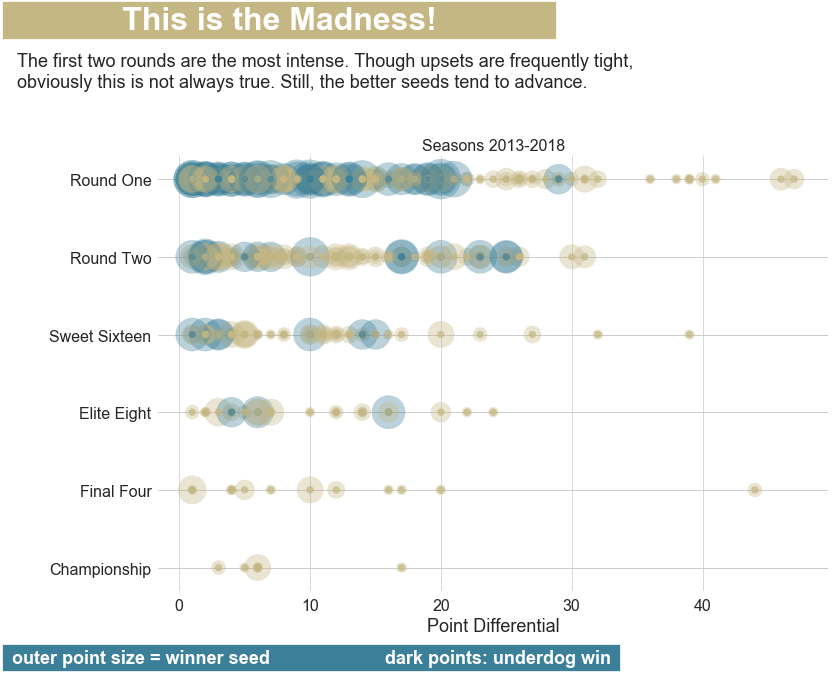

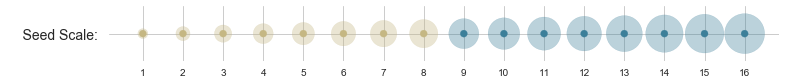

In [121]:
#Save a dataframe of the last 5 years and only games between the final 64 tournament teams:
madness = df_tourney_all[(df_tourney_all.Season >= 2013) & (df_tourney_all.tourn_round <= 64)]
madness.sort_values(by='tourn_round', ascending=False, inplace=True)

colors = np.where(madness.Wseed > 8, '#3c7f99', '#c5b783')
point_size = madness.Wseed*100

rounds = ('Round One', 'Round Two', 'Sweet Sixteen', 'Elite Eight', 'Final Four', 'Championship')

# Plot point differential by round, using color and size to reveal winning seed characteristics:
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.35, s=point_size)
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.75)
plt.box(False) # get rid of border

# Titles and subtitles:
fig.text(x=-0.05, y=1.1, s='             This is the Madness!             ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
fig.text(x=-0.05, y=1, s='  The first two rounds are the most intense. Though upsets are frequently tight, \n  obviously this is not always true. Still, the better seeds tend to advance.', fontsize=18)
plt.title('Seasons 2013-2018', fontsize=16)

# Reverse the y-axis to reflect tournament progression:
plt.ylim(plt.ylim()[::-1])

# Tick marks and labels, x-axis label -
# Get rid of tick marks:
plt.tick_params(axis='both', which='both', length=0)

# Set tick label font size:
plt.tick_params(axis='both', which='major', labelsize=16)

# Label y-ticks according to tourney round:
plt.yticks(np.arange(len(rounds)), rounds)

# Label x-axis and show grid lines:
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xlabel('Point Differential', fontsize=18)

# Add an info bar at the bottom:
fig.text(x=-0.05, y=0, s=' outer point size = winner seed                       dark points: underdog win ', fontsize=18, weight='bold', color='white', backgroundcolor='#3c7f99')

# Show the full scale of winning seed representation:
plot_seed_scale();

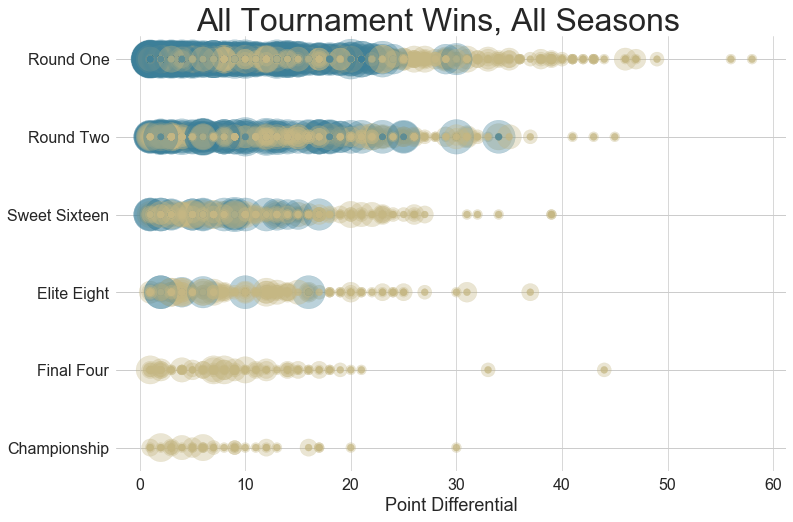

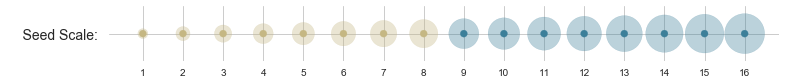

In [122]:
# Save dataframe plot to include all seasons and only games between the final 64 tournament teams:
madness = df_tourney_all[df_tourney_all.tourn_round <= 64]
madness.sort_values(by='tourn_round', ascending=False, inplace=True)

colors = np.where(madness.Wseed > 8, '#3c7f99', '#c5b783')
point_size = madness.Wseed*100

fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.35, s=point_size)
plt.scatter(madness.point_diff, madness.tourn_round.astype(str), color=colors, alpha=0.75)
plt.box(False)

plt.title('All Tournament Wins, All Seasons   ', fontsize=32)

# Reverse the y-axis:
plt.ylim(plt.ylim()[::-1])

# Tick marks and labels, x-axis label -
plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(np.arange(len(rounds)), rounds)
ax.xaxis.grid(which='both', linewidth=0.75)
plt.xlabel('Point Differential', fontsize=18)

plot_seed_scale();

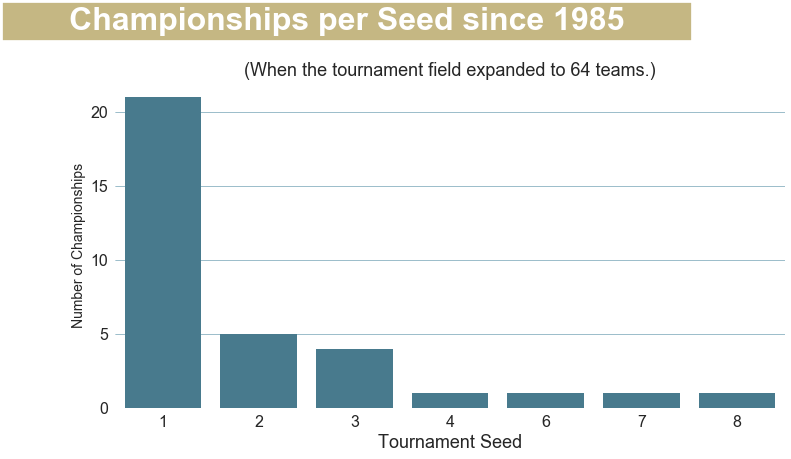

In [123]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 2].Wseed, color='#3c7f99')
plt.box(False)

fig.text(x=0, y=1, s='       Championships per Seed since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

ax.yaxis.set_major_locator(MaxNLocator(integer=True, steps=[1, 2, 5, 10]))
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Number of Championships', fontsize=14), plt.xlabel('Tournament Seed', fontsize=18);

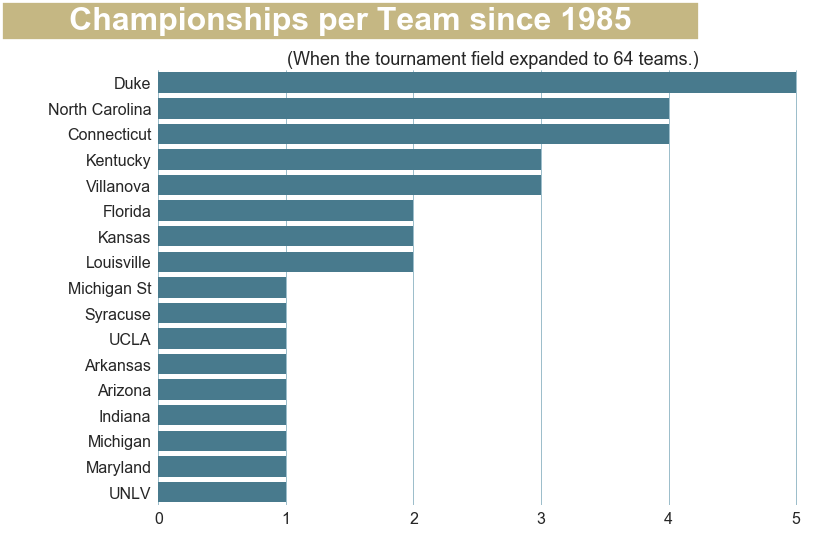

In [124]:
championships = df_tourney_all[df_tourney_all.tourn_round == 2]

fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(y=championships.WTeamName, order=championships.WTeamName.value_counts().index, color='#3c7f99')
plt.box(False)

fig.text(x=-0.05, y=0.95, s='       Championships per Team since 1985       ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

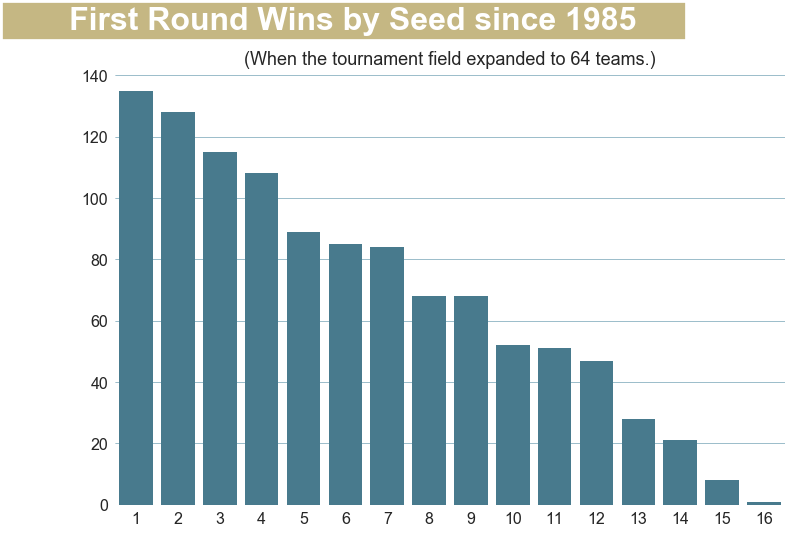

In [125]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(x=df_tourney_all[df_tourney_all.tourn_round == 64].Wseed, color='#3c7f99')
plt.box(False)

fig.text(x=0, y=0.95, s='       First Round Wins by Seed since 1985     ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.title('(When the tournament field expanded to 64 teams.)', fontsize=18)

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel(''), plt.ylabel('');

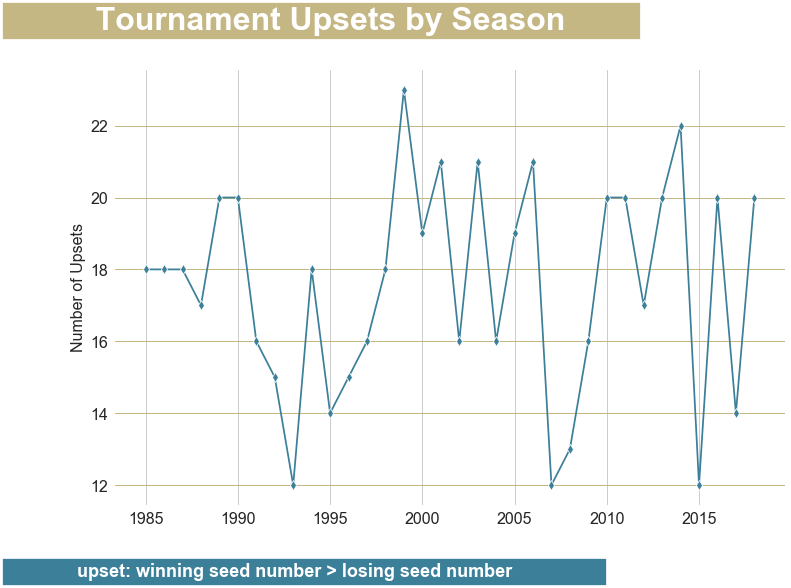

In [126]:
upsets = df_tourney_all[df_tourney_all.Wseed > df_tourney_all.Lseed]
upset_counts = upsets.groupby(['Season'], as_index=False).Wseed.count().rename(columns={'Wseed': 'upset_count'})

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=upset_counts.Season, y=upset_counts.upset_count, marker='d', color='#3c7f99')
plt.box(False)

fig.text(x=0, y=0.95, s='          Tournament Upsets by Season        ', fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')

plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.yaxis.grid(which='both', color='#c5b783')
plt.xlabel(''), plt.ylabel('Number of Upsets', fontsize=16)

# Add an info bar at the bottom:
fig.text(x=0, y=0, s='              upset: winning seed number > losing seed number                  ', fontsize=18, weight='bold', color='white', backgroundcolor='#3c7f99');

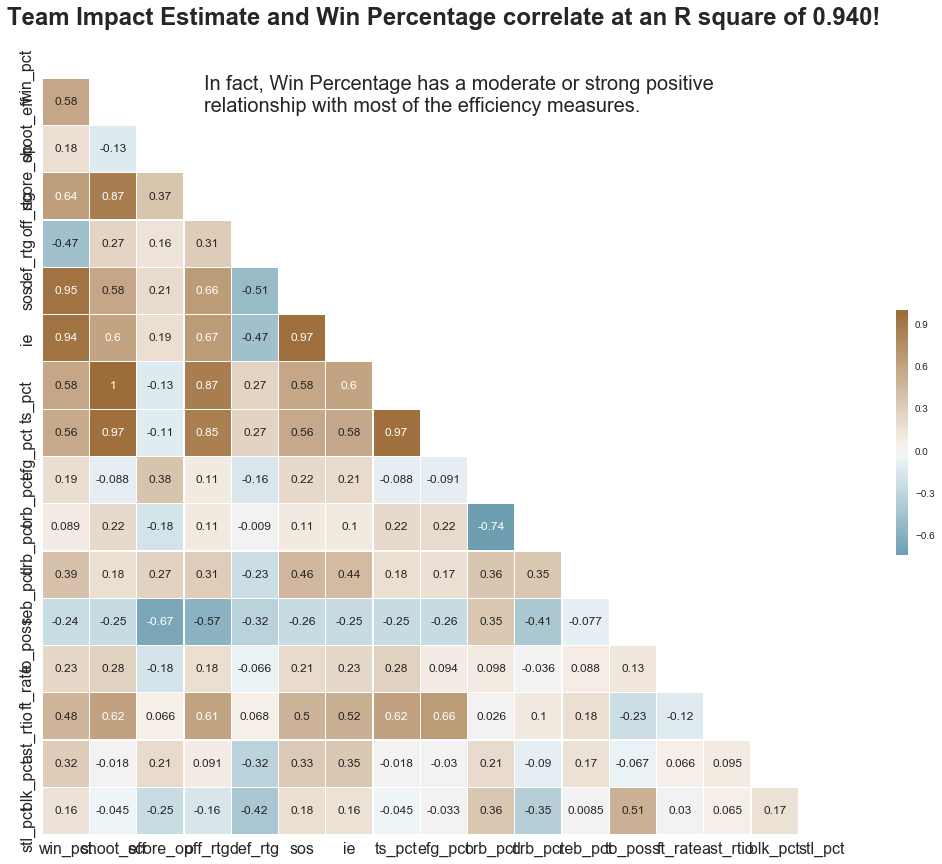

In [129]:
fig = plt.figure(figsize=(18, 18))

# Save the correlation matrix:
matrix = df_avgs[['win_pct', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'ts_pct', 'efg_pct', 'orb_pct', 'drb_pct', 'reb_pct', 'to_poss', 'ft_rate', 'ast_rtio', 'blk_pct', 'stl_pct']].corr()

# Create mask for the upper triangle:
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create a custom diverging colormap:
cmap = sns.diverging_palette(225, 45, as_cmap=True)

sns.heatmap(matrix, mask=mask, cmap=cmap, center=0, annot=True, square=True, linewidths=0.25, cbar_kws={'shrink': 0.25})
plt.tick_params(axis='both', which='both',length=0)
plt.tick_params(axis='both', which='major', labelsize=16)

from scipy.stats.stats import pearsonr
plt.title('Team Impact Estimate and Win Percentage correlate at an R square of {:0.3f}!'.format(pearsonr(df_avgs.ie, df_avgs.win_pct)[0]), fontsize=24, weight='bold')
fig.text(x=0.25, y=0.75, s='In fact, Win Percentage has a moderate or strong positive \nrelationship with most of the efficiency measures.', fontsize=20);

### Features to Model

In [149]:
df_features = df_avgs[['Season', 'TeamID', 'shoot_eff', 'score_op', 'off_rtg', 'def_rtg', 'sos', 'ie', 'efg_pct', 'to_poss', 'orb_pct', 'ft_rate', 'reb_pct', 'drb_pct', 'ts_pct', 'ast_rtio', 'blk_pct', 'stl_pct']]
df_features.head()

,Season,TeamID,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct
0,2003,1102,1.157992,0.912308,104.865089,108.891909,-4.026821,46.353379,0.556399,0.224084,0.281494,0.281172,0.513663,0.745833,57.899587,15.043055,6.244552,11.339317
1,2003,1103,1.178634,0.960977,113.080027,113.577449,-0.497421,49.572422,0.549879,0.195595,0.350337,0.342413,0.501137,0.651936,58.931685,15.515524,5.381451,9.435123
2,2003,1104,1.032297,0.981914,101.342274,97.144558,4.197716,53.381854,0.479505,0.201484,0.339413,0.246554,0.507537,0.675662,51.614839,13.517660,9.456247,9.357466
3,2003,1105,0.992582,0.905364,90.226256,97.916657,-7.690401,43.479539,0.448906,0.268965,0.346065,0.296038,0.488291,0.630517,49.629125,12.671506,8.882001,10.655837
4,2003,1106,0.974301,0.934496,90.752040,91.918235,-1.166195,48.275840,0.446706,0.242880,0.329124,0.279248,0.496678,0.664233,48.715074,11.779535,7.753222,12.994214


In [150]:
df_features = pd.merge(df_seeds, df_features, how='left', left_on=['Season', 'TeamID'], right_on=['Season', 'TeamID'])
df_features_trn = df_features[df_features.Season < 2019]

df_tourney = df_tourney_all[(df_tourney_all.Season >= 2003) & (df_tourney_all.Season < 2019)]
df_tourney.reset_index(inplace=True, drop=True)
df_tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,tourn_round,Wseed,Lseed,WTeamName,WConfName,LTeamName,LConfName,point_diff
1043,2017,138,1211,79,1321,73,N,0,32,1,8,Gonzaga,West Coast Conference,Northwestern,Big Ten Conference,6
1044,2005,134,1324,79,1105,69,N,0,68,16,16,Oakland,Mid-Continent Conference,Alabama A&M,Southwest Athletic Conference,10
1045,2014,137,1455,64,1142,37,N,0,64,1,16,Wichita St,Missouri Valley Conference,Cal Poly SLO,Big West Conference,27
1046,2011,136,1361,68,1294,50,N,0,64,2,15,San Diego St,Mountain West Conference,N Colorado,Big Sky Conference,18
1047,2015,135,1352,81,1316,77,N,0,68,16,16,Robert Morris,Northeast Conference,North Florida,Atlantic Sun Conference,4


In [151]:
# Merge tourney games with tourney winners' season features:
df_winners = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features_trn, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df_winners.drop(['TeamID'], inplace=True, axis=1) 

# Merge tourney games with loser features:
df_losers = pd.merge(left=df_tourney[['Season', 'WTeamID', 'LTeamID']], right=df_features_trn, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df_losers.drop(['TeamID'], inplace=True, axis=1)

### Machine Learning

In [152]:
# Create winner target by subtracting loser data from winner data,
# and assigning a value of 1:
df_winner_diff = (df_winners.iloc[:, 3:] - df_losers.iloc[:, 3:])
df_winner_diff['result'] = 1

# Create loser target by subtracting winner data from loser data,
# and assigning a value of 0:
df_loser_diff = (df_losers.iloc[:, 3:] - df_winners.iloc[:, 3:])
df_loser_diff['result'] = 0

# Concatenate winner data with loser data:
df_model = pd.concat((df_winner_diff, df_loser_diff), axis=0)
df_model.head()

,seed,shoot_eff,score_op,off_rtg,def_rtg,sos,ie,efg_pct,to_poss,orb_pct,ft_rate,reb_pct,drb_pct,ts_pct,ast_rtio,blk_pct,stl_pct,result
0,-5,0.075837,-0.041414,2.472499,-7.025353,9.497851,7.464473,0.029454,0.017600,-0.022644,0.047231,0.004361,0.031366,3.791866,0.915826,-2.658720,0.469603,1
1,-3,-0.027370,0.059856,3.277420,-5.131345,8.408765,10.481643,-0.027610,-0.011035,0.074860,0.056376,0.019786,-0.035288,-1.368485,-1.979216,3.001389,-2.623460,1
2,-5,0.155790,-0.001440,15.351639,-1.643518,16.995157,13.101788,0.099832,-0.027069,-0.012423,-0.003688,0.011962,0.036347,7.789490,2.437619,-3.268603,-1.766893,1
3,0,-0.006739,0.008351,0.429112,0.538735,-0.109623,-0.477634,0.001875,-0.003461,-0.004103,-0.043540,0.001232,0.006566,-0.336961,-1.260066,-0.127182,-1.078380,1
4,11,0.067036,0.032860,9.683221,13.205596,-3.522375,-5.552530,0.037532,-0.004426,0.067518,0.030506,0.002823,-0.061873,3.351787,0.466407,-3.561911,1.439621,1


In [153]:
X = df_model.iloc[:, :-1]
y = df_model.result

# Split the dataframe into 55% training and 45% testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=32)

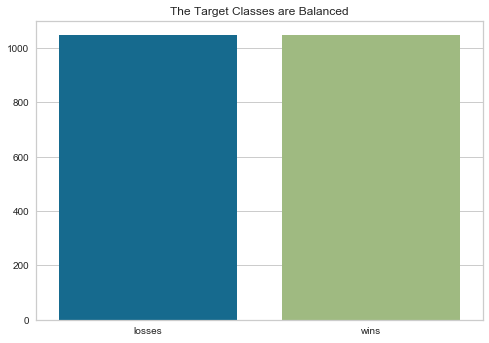

In [154]:
sns.countplot(y)
plt.xlabel(''), plt.ylabel('')
plt.xticks([0, 1], ('losses', 'wins'))
plt.title('The Target Classes are Balanced');

In [155]:
from yellowbrick.classifier import ClassificationReport

def clfy_report(clf, X_train, X_test, y_train, y_test, param_grid, clf_label='clf', cv=10, scale=True):
    """
    Tune classifier hyperparameters and print metrics.
    """
    
    # Create pipeline steps for scaling and classifying:
    if scale:
        pipe = Pipeline([('scaler', StandardScaler()), (clf_label, clf)])
    else:
        pipe = Pipeline([(clf_label, clf)])
    
    # Instantiate grid search using 10-fold cross validation:
    search = GridSearchCV(pipe, param_grid, cv=10)
    
    # Learn relationship between predictors (basketball/tourney features) and outcome,
    # and the best parameters for defining such:
    search.fit(X_train, y_train)
    
    # Predictions on the test set, new data that haven't been introduced to the model:
    predicted = search.predict(X_test)
    
    # Predictions as probabilities:
    probabilities = search.predict_proba(X_test)[:, 1]
    
    # Accuracy scores for the training and test sets:
    train_accuracy = search.score(X_train, y_train)
    test_accuracy = search.score(X_test, y_test)

    print('Best Parameters: {}\n'.format(search.best_params_))
    print('Training Accuracy: {:0.2}'.format(train_accuracy))
    print('Test Accuracy: {:0.2}\n'.format(test_accuracy))
    
    # Confusion matrix labels:
    labels = np.array([['true losses','false wins'], ['false losses','true wins']])
    
    # Model evaluation metrics:
    confusion_mtrx = confusion_matrix(y_test, predicted)
    auc = roc_auc_score(y_test, probabilities)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    logloss = log_loss(y_test, search.predict_proba(X_test))
    
    # Plot all metrics in a grid of subplots:
    fig = plt.figure(figsize=(12, 12))
    grid = plt.GridSpec(2, 4, wspace=0.75, hspace=0.5)
    
    # Top-left plot - confusion matrix:
    plt.subplot(grid[0, :2])
    sns.heatmap(confusion_mtrx, annot=labels, fmt='')
    plt.xlabel('Predicted Games')
    plt.ylabel('Actual Games');
    
    # Top-right plot - ROC curve:
    plt.subplot(grid[0, 2:])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC: {:0.3}'.format(auc));
    
    # Bottom-left plot - support, or true predictions:
    plt.subplot(grid[1, :2])
    sns.countplot(y=predicted, orient='h')
    plt.yticks([1, 0], ('wins', 'losses'))
    plt.ylabel(''), plt.xlabel('Number Predicted');
    
    # Bottom-right plot - classification report:
    plt.subplot(grid[1, 2:])
    visualizer = ClassificationReport(search, classes=['losses', 'wins'])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    g = visualizer.poof();
    
    return train_accuracy, test_accuracy, auc, logloss

In [156]:
def summary_of_models(train_accuracy, test_accuracy, auc, logloss, model_name='model_name'):
    
    model_name = pd.DataFrame({
        'model_name': model_name, 
        'Train Accuracy': round(train_accuracy, 3), 
        'Test Accuracy': round(test_accuracy, 3),
        'AUROC': round(auc, 3),
        'Log Loss': round(logloss, 3)
    }, index=[0])
    model_name = model_name[['model_name', 'Train Accuracy', 'Test Accuracy', 'AUROC', 'Log Loss']]
    
    return model_name

### Logistic Regression

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}

Training Accuracy: 0.72
Test Accuracy: 0.7



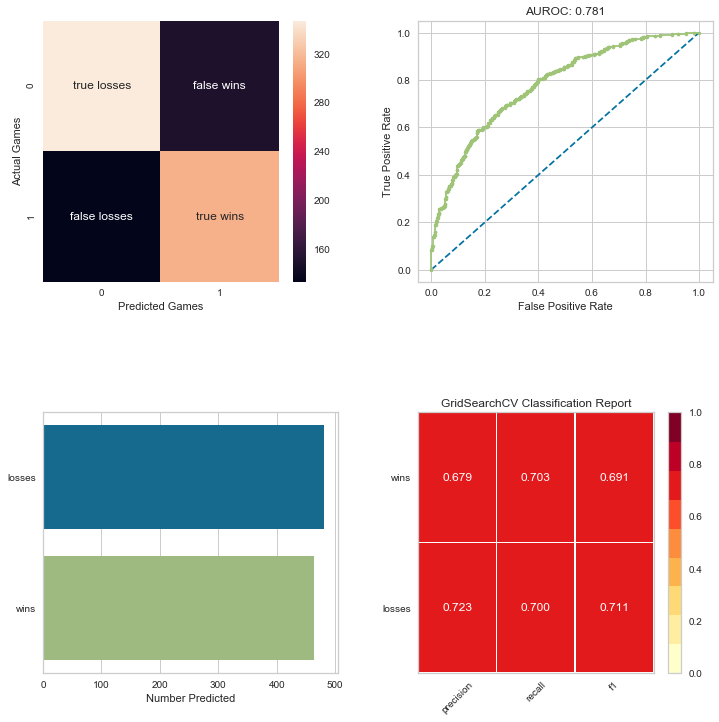

In [157]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn.linear_model import LogisticRegression

# Tune Logistic Regression for optimal regularization strength
# and regularization method (penalty):
lr_clf = LogisticRegression(random_state=32)
lr_param_grid = {
    'clf__C': np.logspace(start=-10, stop=10, num=21),
    'clf__penalty': ['l1', 'l2']
}

train_accuracy, test_accuracy, auc, logloss = clfy_report(lr_clf, X_train, X_test, y_train, y_test, lr_param_grid, cv=10, scale=False)
logisticRegression = summary_of_models(train_accuracy, test_accuracy, auc, logloss, model_name='logisticRegression')

### Support Vector Machines

Best Parameters: {'clf__C': 100.0, 'clf__gamma': 0.001}

Training Accuracy: 0.72
Test Accuracy: 0.7



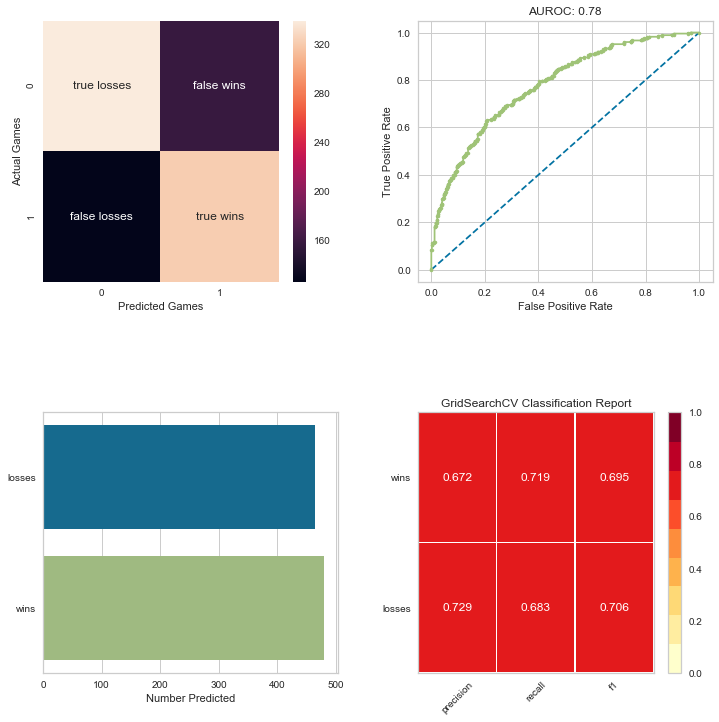

In [158]:
from sklearn import svm

# Tune Support Vector classification for optimal regularization strength 
# and the kernel coefficient for the default kernel type implemented, rbf:
svm_clf = svm.SVC(probability=True, random_state=32)
svm_param_grid = {
    'clf__C': np.logspace(start=-3, stop=3, num=7), 
    'clf__gamma': np.logspace(start=-4, stop=-1, num=4)
}

train_accuracy, test_accuracy, auc, logloss = clfy_report(svm_clf, X_train, X_test, y_train, y_test, svm_param_grid, cv=10)
svmSVC = summary_of_models(train_accuracy, test_accuracy, auc, logloss, model_name='svmSVC')

# Start a summary of all models:
all_models = pd.concat([logisticRegression, svmSVC])

### Random Forest

Best Parameters: {'clf__criterion': 'entropy', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 32}

Training Accuracy: 0.88
Test Accuracy: 0.67



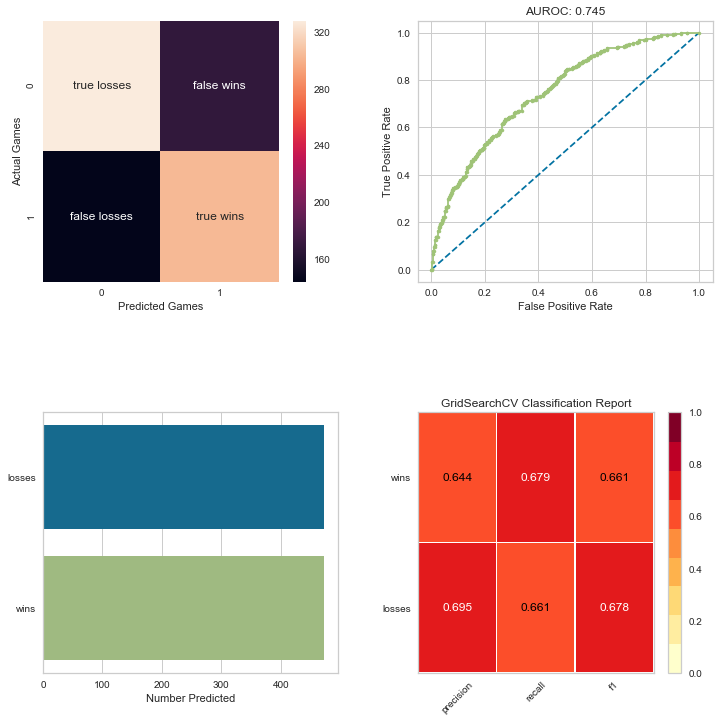

In [159]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=32, n_jobs=-1)
rf_param_grid = {
    'clf__n_estimators': [16, 32, 64, 128],
    'clf__min_samples_leaf': [2, 4, 8, 16], 
    'clf__criterion': ['entropy']
}

train_accuracy, test_accuracy, auc, logloss = clfy_report(rf_clf, X_train, X_test, y_train, y_test, rf_param_grid, cv=10, scale=False)
randomForestClassifier = summary_of_models(train_accuracy, test_accuracy, auc, logloss, model_name='randomForestClassifier')
all_models = pd.concat([all_models, randomForestClassifier])

### XGBoost

Best Parameters: {'clf__colsample_bytree': 0.25, 'clf__max_depth': 2, 'clf__min_child_weight': 2}

Training Accuracy: 0.78
Test Accuracy: 0.68



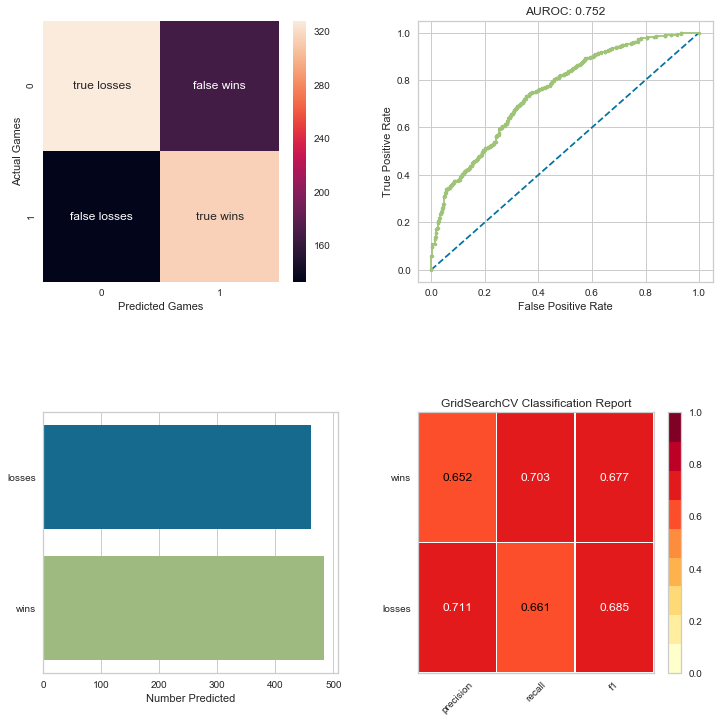

In [160]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=32)
xgb_param_grid = {
    'clf__max_depth': [2, 4, 8, 12],
    'clf__min_child_weight': [2, 4, 8],
    'clf__colsample_bytree': [0.25, 0.5, 0.75]
}

train_accuracy, test_accuracy, auc, logloss = clfy_report(xgb_clf, X_train, X_test, y_train, y_test, xgb_param_grid, cv=10)
xgbClassifier = summary_of_models(train_accuracy, test_accuracy, auc, logloss, model_name='xgbClassifier')
all_models = pd.concat([all_models, xgbClassifier])

In [161]:
# Sort all models by Test Accuracy:
compare_models = all_models.copy()
compare_models.set_index('model_name', inplace=True)
compare_models.sort_values(by=['Test Accuracy', 'AUROC'], ascending=False)

,Train Accuracy,Test Accuracy,AUROC,Log Loss
model_name,,,,
logisticRegression,0.720,0.701,0.781,0.559
svmSVC,0.720,0.700,0.780,0.561
xgbClassifier,0.778,0.681,0.752,0.584
randomForestClassifier,0.881,0.669,0.745,0.597


In [162]:
# Sort all models by Log Loss:
compare_models.sort_values(by=['Log Loss'], ascending=True)

,Train Accuracy,Test Accuracy,AUROC,Log Loss
model_name,,,,
logisticRegression,0.720,0.701,0.781,0.559
svmSVC,0.720,0.700,0.780,0.561
xgbClassifier,0.778,0.681,0.752,0.584
randomForestClassifier,0.881,0.669,0.745,0.597


### Explainability

#### Logistic

In [163]:
# Create pipeline for scaling and classifying:
pipe = Pipeline([('clf', lr_clf)])
    
lr_search = GridSearchCV(pipe, lr_param_grid, cv=10)
lr_search.fit(X_train, y_train)

# To manually enter for the model fit in the next cell:
print(lr_search.best_params_)

perm = PermutationImportance(lr_search, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

{'clf__C': 0.1, 'clf__penalty': 'l2'}


Weight,Feature
0.1201 ± 0.0247,seed
0.0835 ± 0.0285,sos
0.0273 ± 0.0184,ie
0.0083 ± 0.0084,off_rtg
0.0004 ± 0.0010,ft_rate
0.0002 ± 0.0025,ast_rtio
0.0002 ± 0.0008,orb_pct
0 ± 0.0000,shoot_eff
0 ± 0.0000,score_op
0 ± 0.0000,to_poss


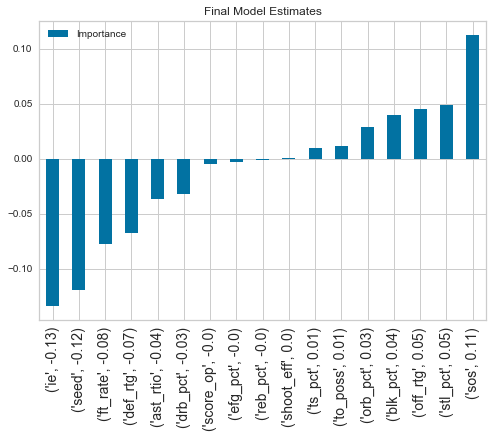

In [164]:
lr = lr_search.best_estimator_.named_steps['clf']
coef = pd.DataFrame({'Features': X.columns, 'Importance': lr.coef_[0]})[['Features', 'Importance']].sort_values(by='Importance')
labels = list(zip(coef.Features, round(coef.Importance, 2)))

coef.plot(kind='bar', title='Final Model Estimates')
plt.xticks(coef.reset_index().index, labels, fontsize=14);

#### XG Boost

In [165]:
# Create pipeline for scaling and classifying:
pipe = Pipeline([('clf', xgb_clf)])
    
xgb_search = GridSearchCV(pipe, xgb_param_grid, cv=10)
xgb_search.fit(X_train.values, y_train.values)

# To manually enter for the model fit in the next cell:
print(xgb_search.best_params_)

perm_xgb = PermutationImportance(xgb_search).fit(X_test.values, y_test.values)
eli5.show_weights(perm_xgb, feature_names=X_test.columns.tolist())

{'clf__colsample_bytree': 0.25, 'clf__max_depth': 2, 'clf__min_child_weight': 2}


Weight,Feature
0.0816 ± 0.0296,seed
0.0117 ± 0.0169,sos
0.0091 ± 0.0074,ie
0.0070 ± 0.0075,off_rtg
0.0055 ± 0.0104,stl_pct
0.0042 ± 0.0038,ft_rate
0.0038 ± 0.0056,score_op
0.0038 ± 0.0095,blk_pct
0.0036 ± 0.0080,to_poss
0.0034 ± 0.0145,drb_pct


### Support Vector Machines

In [166]:
# Create pipeline for scaling and classifying:
pipe = Pipeline([('clf', svm_clf)])
    
svm_search = GridSearchCV(pipe, svm_param_grid, cv=10)
svm_search.fit(X_train.values, y_train.values)

# To manually enter for the model fit in the next cell:
print(svm_search.best_params_)

perm_svm = PermutationImportance(svm_search).fit(X_test.values, y_test.values)
eli5.show_weights(perm_svm, feature_names=X_test.columns.tolist())

{'clf__C': 1.0, 'clf__gamma': 0.0001}


Weight,Feature
0.1169 ± 0.0128,seed
0.0068 ± 0.0117,off_rtg
0.0051 ± 0.0191,sos
0.0034 ± 0.0045,blk_pct
0.0023 ± 0.0034,ts_pct
0.0015 ± 0.0010,ast_rtio
0 ± 0.0000,efg_pct
0 ± 0.0000,shoot_eff
0 ± 0.0000,score_op
0 ± 0.0000,to_poss


### Random Forest

In [167]:
# Create pipeline for scaling and classifying:
pipe = Pipeline([('clf', rf_clf)])
    
rf_search = GridSearchCV(pipe, rf_param_grid, cv=10)
rf_search.fit(X_train.values, y_train.values)

# To manually enter for the model fit in the next cell:
print(rf_search.best_params_)

perm_rf = PermutationImportance(rf_search).fit(X_test.values, y_test.values)
eli5.show_weights(perm_rf, feature_names=X_test.columns.tolist())

{'clf__criterion': 'entropy', 'clf__min_samples_leaf': 8, 'clf__n_estimators': 32}


Weight,Feature
0.0506 ± 0.0110,seed
0.0123 ± 0.0064,ft_rate
0.0028 ± 0.0048,reb_pct
0.0017 ± 0.0084,efg_pct
0.0013 ± 0.0087,sos
0.0006 ± 0.0039,stl_pct
-0.0017 ± 0.0104,orb_pct
-0.0019 ± 0.0108,ts_pct
-0.0030 ± 0.0106,blk_pct
-0.0038 ± 0.0091,drb_pct


### Predictions and Bracket

In [168]:
df_predict = pd.read_csv('SampleSubmissionStage2.csv')
df_predict.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [169]:
def get_year_team1_team2(ID):
    """Return a tuple with the year, team1 and team2
    for each ID in the sample submission file of possible matches."""
    return (int(x) for x in ID.split('_'))

In [170]:
def predict_poss_matches(clf, df_predict=df_predict, df_features=df_features):
    diff = []
    data = []

    for i, row in df_predict.iterrows():

        year, team1, team2 = get_year_team1_team2(row.ID)

        # Save 2018 stats/features for the first ID:
        team1 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team1)].values[0]

        # Save 2018 stats/features for the first ID:
        team2 = df_features[(df_features['Season'] == year) & (df_features['TeamID'] == team2)].values[0]   

        diff = team1 - team2

        data.append(diff)

    n_poss_games = len(df_predict)
    columns = df_features.columns.get_values()
    final_predictions = pd.DataFrame(np.array(data).reshape(n_poss_games, np.array(data).shape[1]), columns=(columns))
    final_predictions.drop(['Season', 'TeamID'], inplace=True, axis=1)
    predictions = clf.predict_proba(final_predictions.values)[:, 1]
    clipped_predictions = np.clip(predictions, 0.05, 0.95)
    df_predict.Pred = clipped_predictions
    
    return df_predict



#### Logistic Bracket

In [171]:
predict_poss_matches(lr_search).to_csv('best_model_results.csv', index=False)

In [172]:
from bracketeer import build_bracket

In [174]:
b = build_bracket(
        outputPath='best_bracket.png',
        submissionPath='best_model_results.csv',
        teamsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\Teams.csv',
        seedsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySeeds.csv',
        slotsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySlots.csv',
        year=2019
)

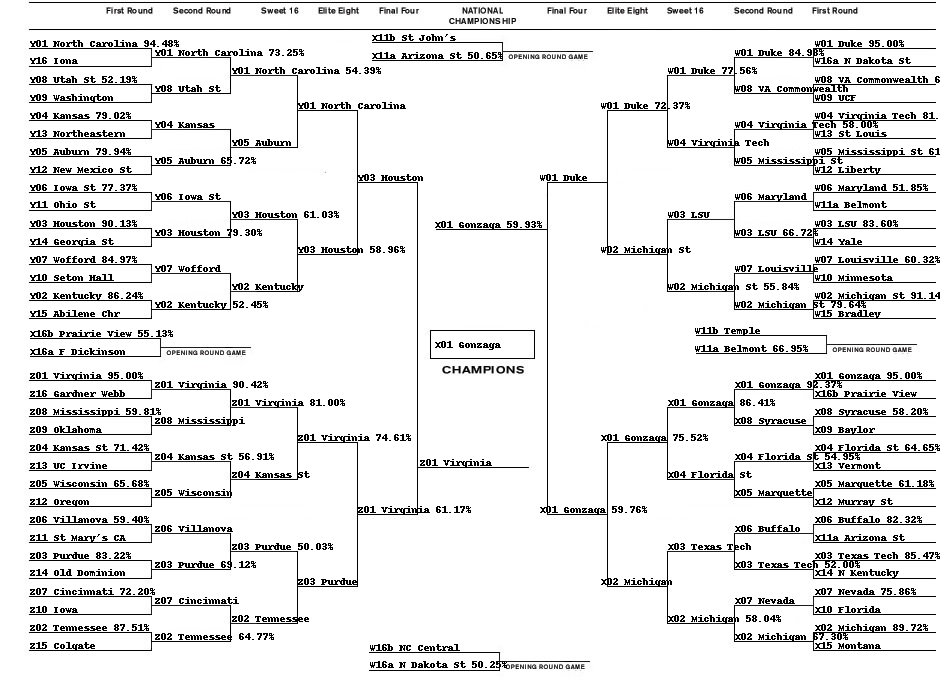

In [175]:
from IPython.display import Image
Image("best_bracket.png")

#### XGboost Results

In [176]:
predict_poss_matches(xgb_search).to_csv('best_model_results_xgb.csv', index=False)

In [177]:
b_xgb = build_bracket(
        outputPath='best_bracket_xgb.png',
        submissionPath='best_model_results_xgb.csv',
        teamsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\Teams.csv',
        seedsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySeeds.csv',
        slotsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySlots.csv',
        year=2019
)

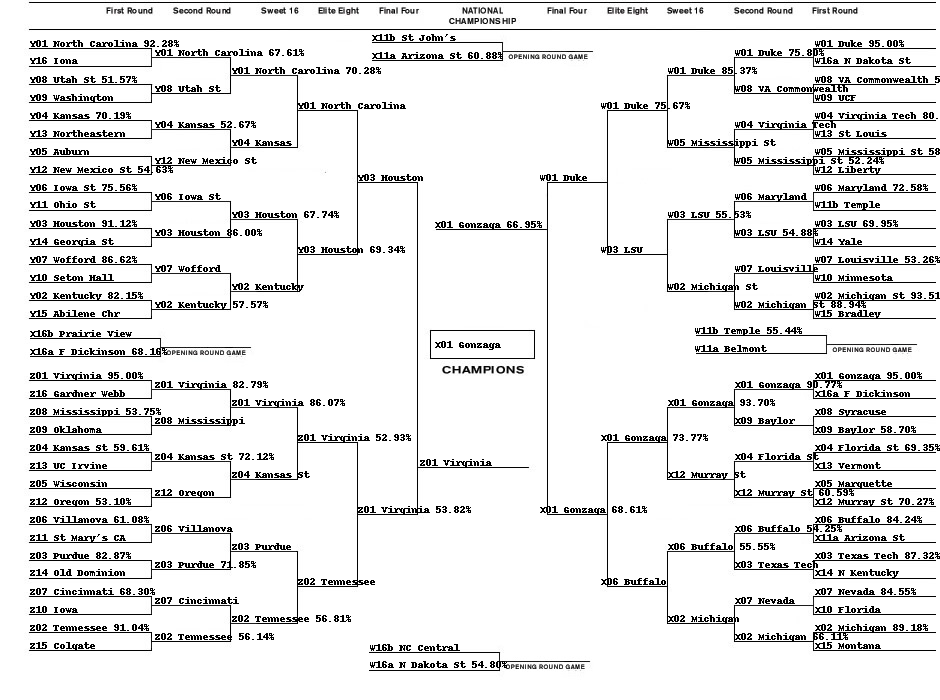

In [178]:
from IPython.display import Image
Image("best_bracket_xgb.png")

### Support Vector Machines

In [179]:
predict_poss_matches(svm_search).to_csv('best_model_results_svm.csv', index=False)

In [180]:
b_svm = build_bracket(
        outputPath='best_bracket_svm.png',
        submissionPath='best_model_results_svm.csv',
        teamsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\Teams.csv',
        seedsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySeeds.csv',
        slotsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySlots.csv',
        year=2019
)

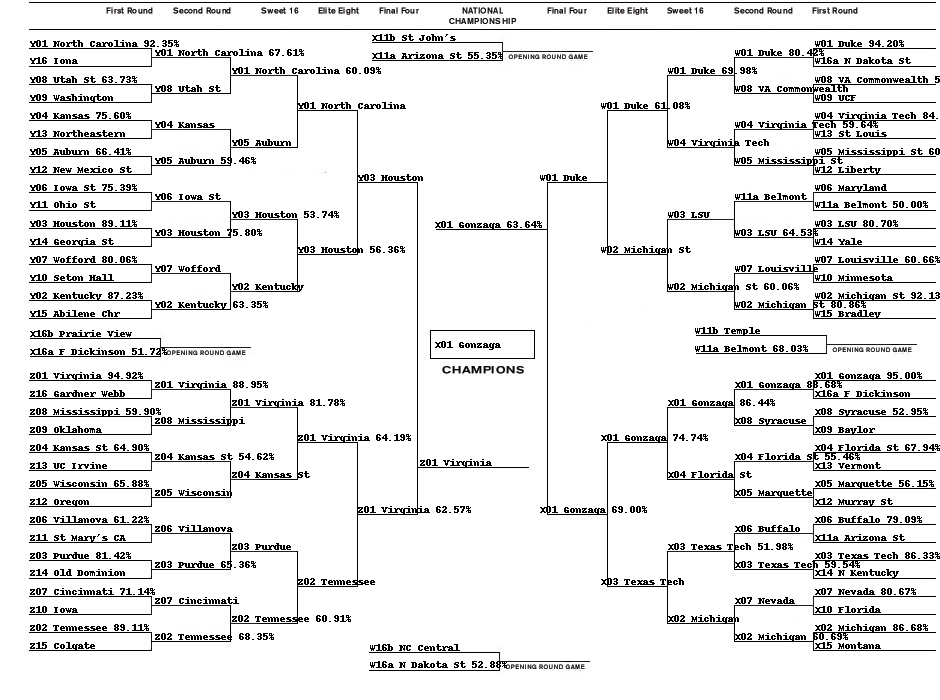

In [181]:
Image("best_bracket_svm.png")

### Random Forest

In [182]:
predict_poss_matches(rf_search).to_csv('best_model_results_rf.csv', index=False)

In [183]:
b_rf = build_bracket(
        outputPath='best_bracket_rf.png',
        submissionPath='best_model_results_rf.csv',
        teamsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\Teams.csv',
        seedsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySeeds.csv',
        slotsPath='C:\\Users\\MaxCarduner\\DS\\NCAA_19_Final\\Data\\NCAATourneySlots.csv',
        year=2019
)

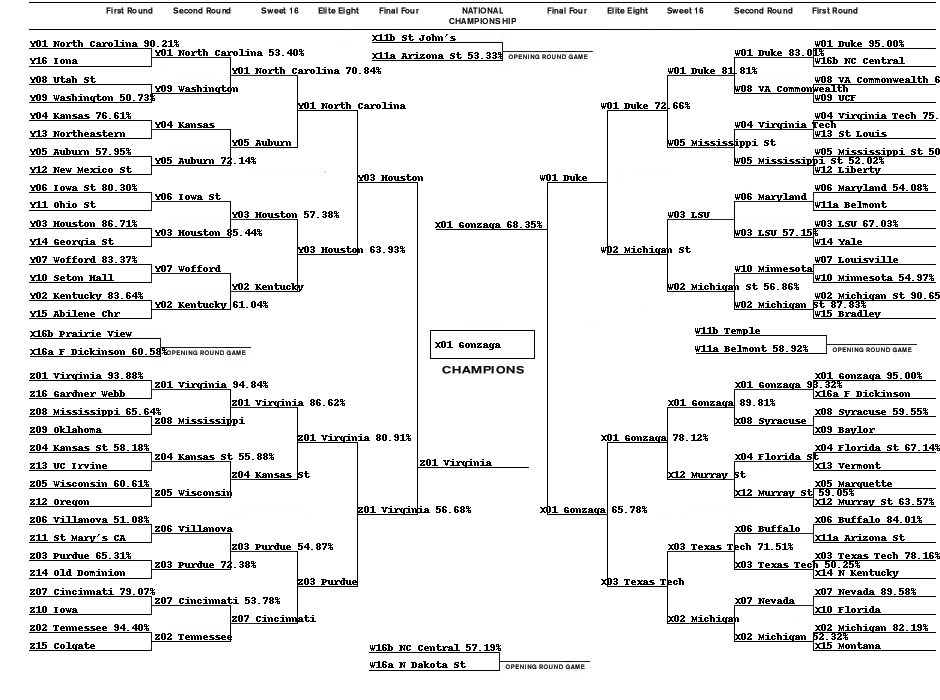

In [184]:
Image("best_bracket_rf.png")